<a href="https://colab.research.google.com/github/June103310110/Image_Segmentation/blob/main/PART1/01_custom_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Albumentation
對影像以及其標記資料同時進行影像增強

![](https://i.imgur.com/ZdU6bHe.jpg)
> ref: https://albumentations.ai/docs/

In [4]:
import gdown

!wget https://raw.githubusercontent.com/June103310110/Image_Segmentation/main/PART2/utils.py -O utils.py

gdown.download('https://drive.google.com/u/1/uc?id=1TJ6Ya4oc7PwiLu6t5seZYdD6APMNKl-h&export=download',
               'capsule.zip')

!unzip -o capsule.zip -d ./data

--2022-03-18 02:24:43--  https://raw.githubusercontent.com/June103310110/Image_Segmentation/main/PART2/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7067 (6.9K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.90K  --.-KB/s    in 0s      

2022-03-18 02:24:43 (59.0 MB/s) - ‘utils.py’ saved [7067/7067]



Downloading...
From: https://drive.google.com/u/1/uc?id=1TJ6Ya4oc7PwiLu6t5seZYdD6APMNKl-h&export=download
To: /content/capsule.zip
100%|██████████| 11.7M/11.7M [00:00<00:00, 138MB/s]


Archive:  capsule.zip
  inflating: ./data/capsule/ground_truth/scratch/000_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/001_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/002_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/003_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/004_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/005_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/006_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/007_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/008_mask.png  
  inflating: ./data/capsule/ground_truth/scratch/009_mask.png  
  inflating: ./data/capsule/test/scratch/000.png  
  inflating: ./data/capsule/test/scratch/001.png  
  inflating: ./data/capsule/test/scratch/002.png  
  inflating: ./data/capsule/test/scratch/003.png  
  inflating: ./data/capsule/test/scratch/004.png  
  inflating: ./data/capsule/test/scratch/005.png  
  inflating: ./data/capsule/test

In [5]:
import albumentations as A
from albumentations import DualTransform
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import torch
from utils import show_image_mask

In [6]:
file = os.listdir(f'{os.getcwd()}/data/capsule/test/scratch/')
file = np.random.choice(file,size=3, replace=False)
file = [i.split('.')[0] for i in file]
file

['003', '009', '006']

### 取得影像資料

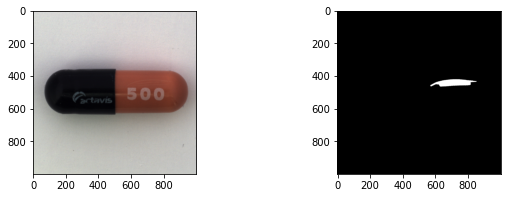

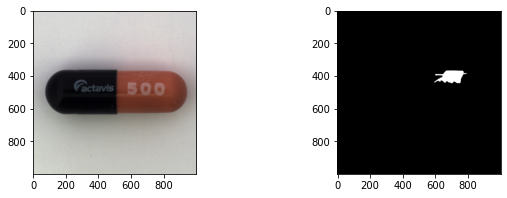

In [7]:
img_mask_list = []
for i in file[:2]:
    image = cv2.imread(f'{os.getcwd()}/data/capsule/test/scratch/{i}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(f'{os.getcwd()}/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)
    img_mask_list.append((image, mask))
    show_image_mask(image, mask)

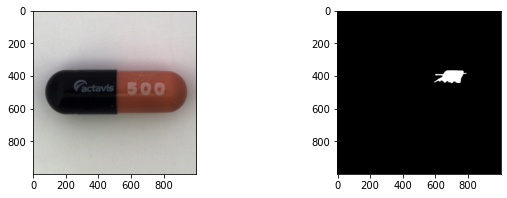

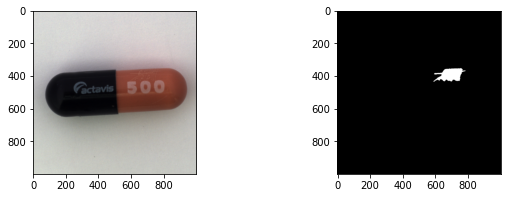

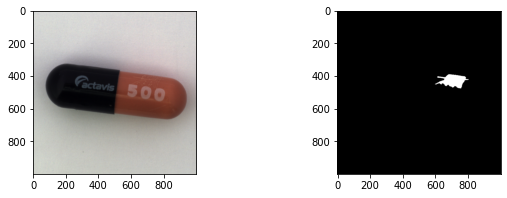

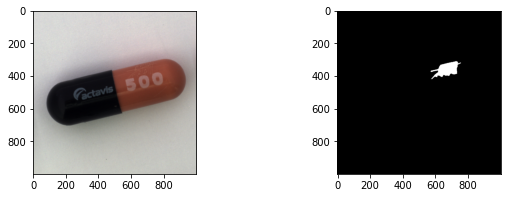

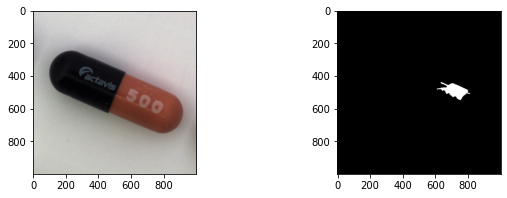

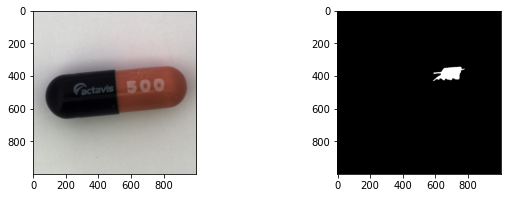

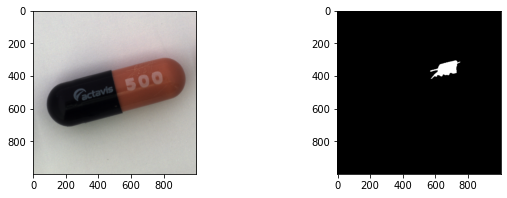

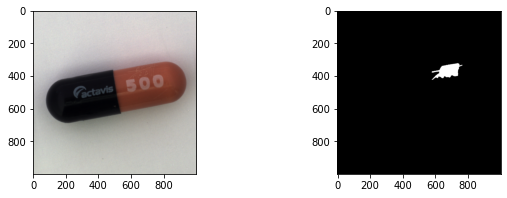

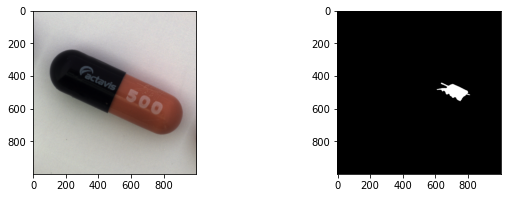

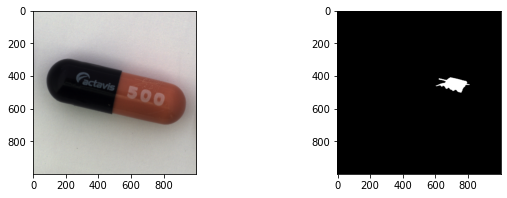

In [13]:

# random.seed(9)
for i in range(10):
  transform = A.Compose([
      A.Rotate((-30, 30), p=1), 
  ])

  transformed  = transform(image=image, mask=mask)
  show_image_mask(transformed['image'], transformed['mask'])

### example: 官方製作的Crop方法
透過apply對image和mask做處理

In [ ]:
class Crop(DualTransform):
    def __init__(self, x_min=0, y_min=0, x_max=1024, y_max=1024, always_apply=False, p=1.0):
        super(Crop, self).__init__(always_apply, p)
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max

    def apply(self, img, **params):
        return A.crop(img, x_min=self.x_min, y_min=self.y_min, x_max=self.x_max, y_max=self.y_max)


### 客製化影像增強 
以稍作修改的Cutmix為例

In [ ]:
class mask_CutMix(DualTransform):
    def __init__(self, img_mask_list, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.img_lis, self.mask_lis = zip(*img_mask_list)
        self.choice = np.random.choice(range(len(self.img_lis)),size=1, replace=False)
        self.seed = 1000
        
    def apply(self, img, **params):
        a = self.choice[0]
#         a = choice[0]
#         b = choice[1]
#         print(a,b)
        source_center = self.find_objects_contours(self.mask_lis[a])
        points, _ = self.center_to_4point(self.mask_lis[a], source_center, 256)
        
        target_image = img
        if len(np.shape(img)) == 2:
            source_image = self.mask_lis[a]
        else:
            source_image = self.img_lis[a]
            self.seed = np.random.choice(range(10000),size=1)[0]
        
    
        x_min, y_min, x_max, y_max = points
        target_image = target_image.copy()
        piece = source_image[y_min:y_max, x_min:x_max]
        
        
        transform = A.Compose([
                A.Rotate((-30, 30), p=1), 
                A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
                A.HorizontalFlip(p=0.5),
            ])
        random.seed(self.seed)
        transformed  = transform(image=piece)

        
        target_image[y_min:y_max, x_min:x_max] = transformed['image']
        return target_image
        
    def find_objects_contours(self, mask):
        thresh = mask
        contours, hier = \
            cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        np.shape(contours)

        center = np.array(contours).reshape(-1,2)
        center = center.mean(axis=0)
        return center

    def center_to_4point(self, mask, arr, side_width, pad=None):
        limit = len(mask)
        points = [0]*4

        if not pad:
            pad = 0
        value = side_width/2+pad    
        for i in arr:
            if side_width+2*pad > limit:
                print(side_width+2*pad)
                raise ValueError('not enough')
            if i > limit:
                raise ValueError('not include')

        for i in range(len(points)):
            if i in [0,1]:
                if arr[i%2] - value < 0:
                    points[i] = 0
                    points[i+2] += np.abs(arr[i%2] - value)
                else:
                    points[i] = arr[i%2]-value
            if i in [2,3]:
                if arr[i%2]+value > limit:
                    print(arr[i%2]+value)
                    points[i] = len(mask)
                    points[i-2] -= np.abs(limit - arr[i%2] - value)
                else:
                    points[i] = arr[i%2]+value
        points = np.round(points).astype(int) 
        x_min, y_min, x_max, y_max = points
        return points, mask[y_min:y_max, x_min:x_max]


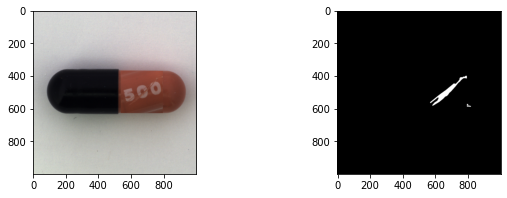

In [ ]:
transform = A.Compose([
    mask_CutMix(img_mask_list),
#     Crop(x_max=1000, y_max=1000)
])

transformed  = transform(image=image, mask=mask)
show_image_mask(transformed['image'], transformed['mask'])